Columns: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4']
Number of examples: 6000


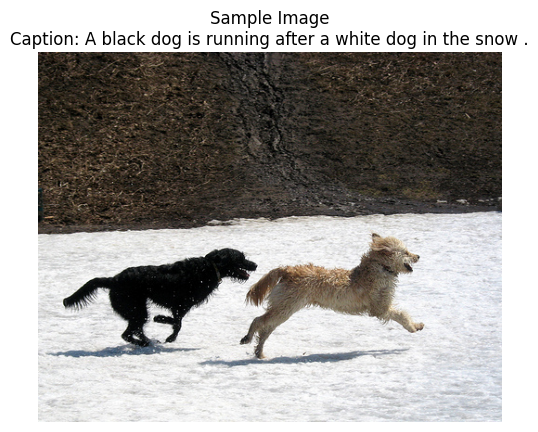

In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, AutoModelForCausalLM
from datasets import load_dataset
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# =======================================================
# 3. Load Flickr8k dataset
# =======================================================
#dataset = load_dataset("jxie/flickr8k")
flickr_data = dataset = load_dataset("jxie/flickr8k",split="train")

print(f"Columns: {flickr_data.column_names}")
print(f"Number of examples: {len(flickr_data)}")

# =======================================================
# 4. Image transforms
# =======================================================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

# =======================================================
# 5. Test image loading
# =======================================================
sample_img = flickr_data[0]['image']
plt.imshow(sample_img)
plt.title(f"Sample Image\nCaption: {flickr_data[0]['caption_0']}")
plt.axis('off')
plt.show()


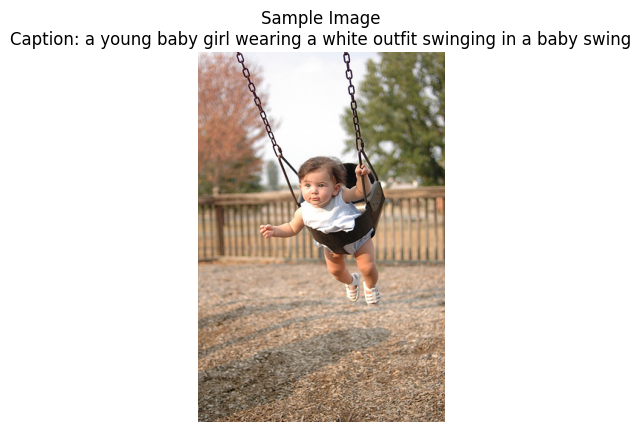

In [13]:
sample_img = flickr_data[5899]['image']
plt.imshow(sample_img)
plt.title(f"Sample Image\nCaption: {flickr_data[5899]['caption_4']}")
plt.axis('off')
plt.show()

In [14]:
# =======================================================
# 6. Dataset class
# =======================================================
class Flickr8kDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=30, transform=None):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        caption = self.dataset[idx]['caption_0']
        tokenized = self.tokenizer(
            caption,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = tokenized.input_ids.squeeze(0)
        attention_mask = tokenized.attention_mask.squeeze(0)
        return image, input_ids, attention_mask

# =======================================================
# 7. Load tokenizer + model
# =======================================================
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

# Add special <img> token
if '<img>' not in tokenizer.get_vocab():
    tokenizer.add_special_tokens({'additional_special_tokens':['<img>']})
img_token_id = tokenizer.convert_tokens_to_ids('<img>')

# Load DistilGPT2 via AutoModelForCausalLM
gpt2 = AutoModelForCausalLM.from_pretrained("distilgpt2")
gpt2.resize_token_embeddings(len(tokenizer))
gpt2.eval()

# =======================================================
# 8. Q-Former
# =======================================================
from transformers import ViTModel
vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit.eval()

class QFormer(nn.Module):
    def __init__(self, image_emb_dim, prompt_len=16, hidden_dim=768):
        super().__init__()
        self.query_tokens = nn.Parameter(torch.randn(prompt_len, image_emb_dim))
        self.cross_attn = nn.MultiheadAttention(embed_dim=image_emb_dim, num_heads=8)
        self.mlp = nn.Linear(image_emb_dim, hidden_dim)

    def forward(self, image_embeds):
        batch_size = image_embeds.size(0)
        query = self.query_tokens.unsqueeze(1).repeat(1,batch_size,1)
        attn_out,_ = self.cross_attn(query, image_embeds.transpose(0,1), image_embeds.transpose(0,1))
        prompt = self.mlp(attn_out).transpose(0,1)
        return prompt

q_former = QFormer(image_emb_dim=vit.config.hidden_size, prompt_len=16, hidden_dim=gpt2.config.n_embd)

# =======================================================
# 9. DataLoader
# =======================================================
train_dataset = Flickr8kDataset(flickr_data, tokenizer, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# =======================================================
# 10. Device setup
# =======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)
gpt2.to(device)
q_former.to(device)


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


QFormer(
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (mlp): Linear(in_features=768, out_features=768, bias=True)
)

In [15]:
# =======================================================
# 11. Partial GPT-2 fine-tuning
# =======================================================
N_LAST_LAYERS = 4  # fine-tune last 4 layers

# Freeze all GPT-2 parameters
for param in gpt2.transformer.parameters():
    param.requires_grad = False

# Unfreeze last N layers
for block in gpt2.transformer.h[-N_LAST_LAYERS:]:
    for param in block.parameters():
        param.requires_grad = True

# Unfreeze embedding for <img> token
for param in gpt2.transformer.wte.parameters():
    param.requires_grad = True

# Unfreeze LM head
for param in gpt2.lm_head.parameters():
    param.requires_grad = True

# Optimizer for trainable params
trainable_params = filter(lambda p: p.requires_grad, gpt2.parameters())
optimizer = torch.optim.AdamW(list(trainable_params) + list(q_former.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# =======================================================
# 12. Training loop (demo)
# =======================================================
for epoch in range(1):  # increase to 5–10 epochs for better results
    q_former.train()
    gpt2.train()
    total_loss = 0
    for images, input_ids, attention_mask in tqdm(train_loader):
        images, input_ids = images.to(device), input_ids.to(device)

        with torch.no_grad():
            image_embeds = vit(images).last_hidden_state

        prompts = q_former(image_embeds)

        # Prepend <img> token
        img_token_emb = gpt2.transformer.wte(torch.tensor([img_token_id]*images.size(0), device=device).unsqueeze(1))
        gpt2_inputs = gpt2.transformer.wte(input_ids)
        gpt2_inputs = torch.cat([img_token_emb, prompts, gpt2_inputs], dim=1)

        outputs = gpt2(inputs_embeds=gpt2_inputs)
        logits = outputs.logits

        prompt_len = 1 + prompts.size(1)
        loss = criterion(logits[:, prompt_len:-1,:].reshape(-1, logits.size(-1)), input_ids[:,1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch} Loss: {total_loss/len(train_loader)}")

# =======================================================
# 13. Inference with top-k/top-p sampling
# =======================================================
def generate_caption(pil_image, vit, q_former, gpt2, tokenizer, device, max_length=30, top_k=50, top_p=0.95):
    vit.eval()
    q_former.eval()
    gpt2.eval()

    image = transform(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embeds = vit(image).last_hidden_state
        prompts = q_former(image_embeds)
        input_ids = torch.tensor([[tokenizer.bos_token_id]], device=device)
        img_token_emb = gpt2.transformer.wte(torch.tensor([[img_token_id]], device=device))
        generated = []

        for _ in range(max_length):
            gpt2_inputs = gpt2.transformer.wte(input_ids)
            gpt2_inputs = torch.cat([img_token_emb, prompts, gpt2_inputs], dim=1)

            outputs = gpt2(inputs_embeds=gpt2_inputs)
            logits = outputs.logits[0, -1, :]

            # Top-k + top-p sampling
            filtered_logits = torch.nn.functional.softmax(logits, dim=-1)
            next_token = torch.multinomial(filtered_logits, num_samples=1)

            if next_token.item() == tokenizer.eos_token_id:
                break
            generated.append(next_token.item())
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

        caption = tokenizer.decode(generated, skip_special_tokens=True)
        return caption

# =======================================================
# 14. Test generated captions
# =======================================================
for i in range(3):
    img = flickr_data[i]['image']
    gt_caption = flickr_data[i]['caption_0']
    gen_caption = generate_caption(img, vit, q_former, gpt2, tokenizer, device)

    print("GT caption: " + gt_caption)
    print("Generated caption: " + gen_caption)

    #plt.imshow(img)
    #plt.title(f"GT: {gt_caption}\nGenerated: {gen_caption}")
    #plt.axis('off')
   # plt.show()

100%|██████████| 1500/1500 [11:58<00:00,  2.09it/s]


Epoch 0 Loss: 3.091209995985031
GT caption: A black dog is running after a white dog in the snow .
Generated caption: Image ©Laura McClain, Red Hat Nature Service




One golden Frisbee is hungry , while another black Frisbee looks
GT caption: A little baby plays croquet .
Generated caption: Protesters in an industrial setting face down at night . Tourists walk through the desert . what young people say is a scene from something funny . Their
GT caption: A brown dog in the snow has something hot pink in its mouth .
Generated caption: The former woman and a black dog are in big red puddle in a slicker bag . One brown dog playing on the sofa . The woman and


In [16]:
for epoch in range(10):  # increase to 5–10 epochs for better results
    q_former.train()
    gpt2.train()
    total_loss = 0
    for images, input_ids, attention_mask in tqdm(train_loader):
        images, input_ids = images.to(device), input_ids.to(device)

        with torch.no_grad():
            image_embeds = vit(images).last_hidden_state

        prompts = q_former(image_embeds)

        # Prepend <img> token
        img_token_emb = gpt2.transformer.wte(torch.tensor([img_token_id]*images.size(0), device=device).unsqueeze(1))
        gpt2_inputs = gpt2.transformer.wte(input_ids)
        gpt2_inputs = torch.cat([img_token_emb, prompts, gpt2_inputs], dim=1)

        outputs = gpt2(inputs_embeds=gpt2_inputs)
        logits = outputs.logits

        prompt_len = 1 + prompts.size(1)
        loss = criterion(logits[:, prompt_len:-1,:].reshape(-1, logits.size(-1)), input_ids[:,1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch} Loss: {total_loss/len(train_loader)}")

100%|██████████| 1500/1500 [12:08<00:00,  2.06it/s]


Epoch 0 Loss: 2.5857237697442375


100%|██████████| 1500/1500 [12:32<00:00,  1.99it/s]


Epoch 1 Loss: 2.30554700422287


100%|██████████| 1500/1500 [12:40<00:00,  1.97it/s]


Epoch 2 Loss: 2.057443043708801


100%|██████████| 1500/1500 [13:40<00:00,  1.83it/s]


Epoch 3 Loss: 1.8248937817811965


100%|██████████| 1500/1500 [12:22<00:00,  2.02it/s]


Epoch 4 Loss: 1.6011888188123704


100%|██████████| 1500/1500 [12:31<00:00,  2.00it/s]


Epoch 5 Loss: 1.3765649937391282


100%|██████████| 1500/1500 [12:29<00:00,  2.00it/s]


Epoch 6 Loss: 1.1763132038911184


100%|██████████| 1500/1500 [12:23<00:00,  2.02it/s]


Epoch 7 Loss: 0.9850794188380242


100%|██████████| 1500/1500 [11:35<00:00,  2.16it/s]


Epoch 8 Loss: 0.8308975807825725


100%|██████████| 1500/1500 [43:36<00:00,  1.74s/it]   

Epoch 9 Loss: 0.6876928015947342


GT caption: A group of climbers begin up a sheer rock face .
Generated caption: Larry Summers , the man in the red shirt , climbs a cliff . . back to top . with two other men . . " ' . . .


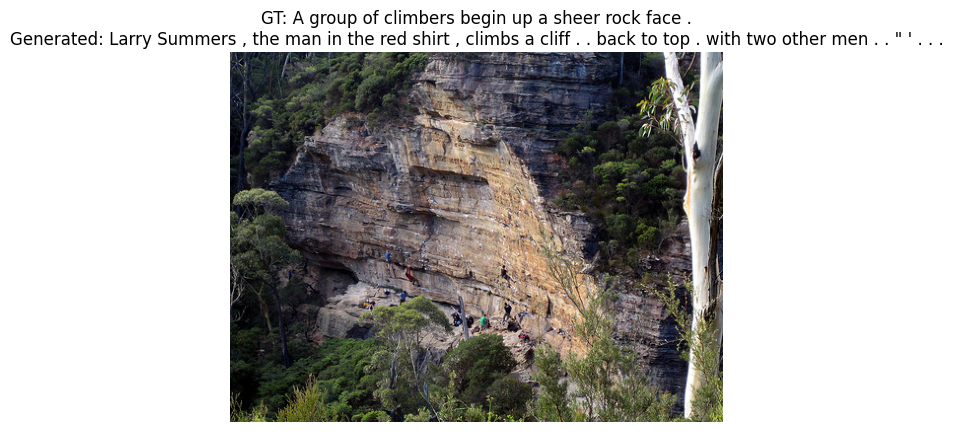

GT caption: A child sits in a plastic toy car .
Generated caption: Children playing in a plastic bag on a playground . . . . . . . . . . People standing around playing . . . . . . .


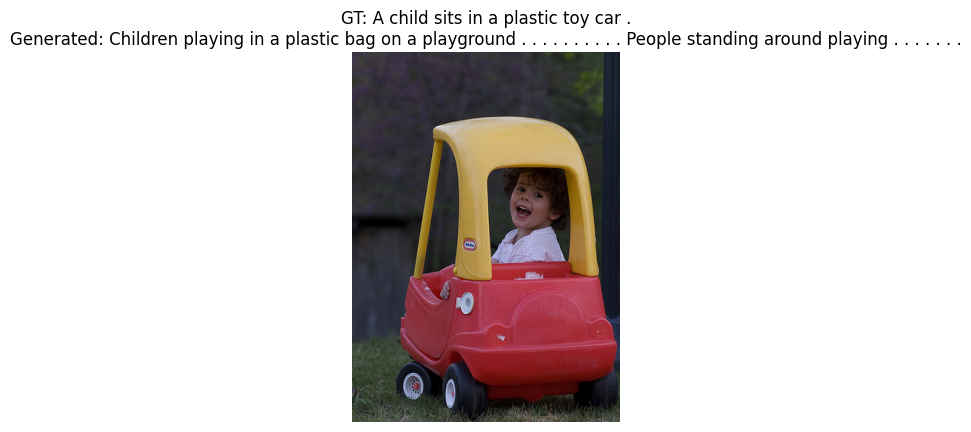

GT caption: two girls hold up a card reading " know what this is " ?
Generated caption: Andy Dalton talks to a girl on a cellphone . . . . . . . . 2 girls wearing red shirts and black pants . . . . .


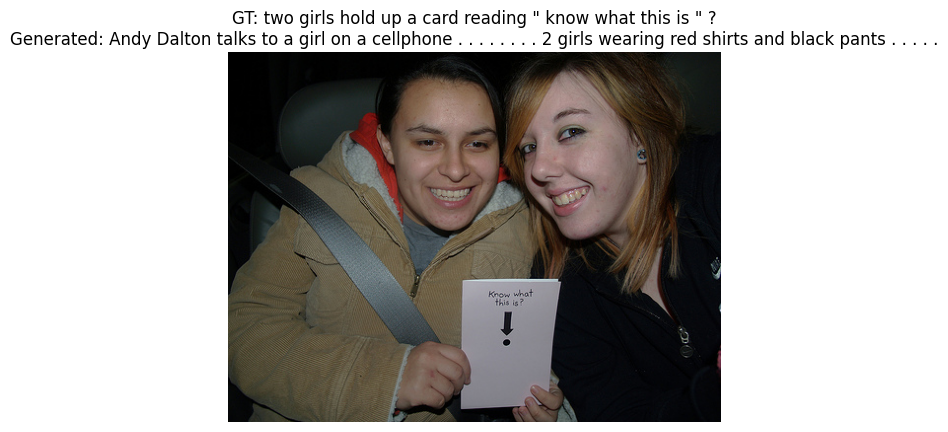

GT caption: A dog runs holding a yellow dog toy in fall , bench in the background .
Generated caption: REGULATIVES OF A dog playing outside on a yellow bench . . . . two dogs are behind the back of the fence . . one has


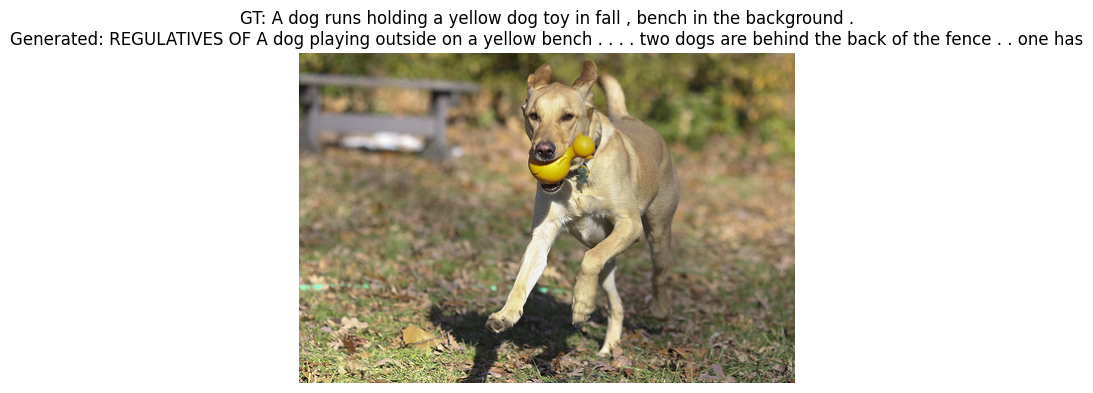

GT caption: a blond girl in a pink bathing suit running through the sprinklers
Generated caption: - Mom helps her little boy swim while putting some water in his hand . . . . . " Mom runs behind her little boy on the chest .


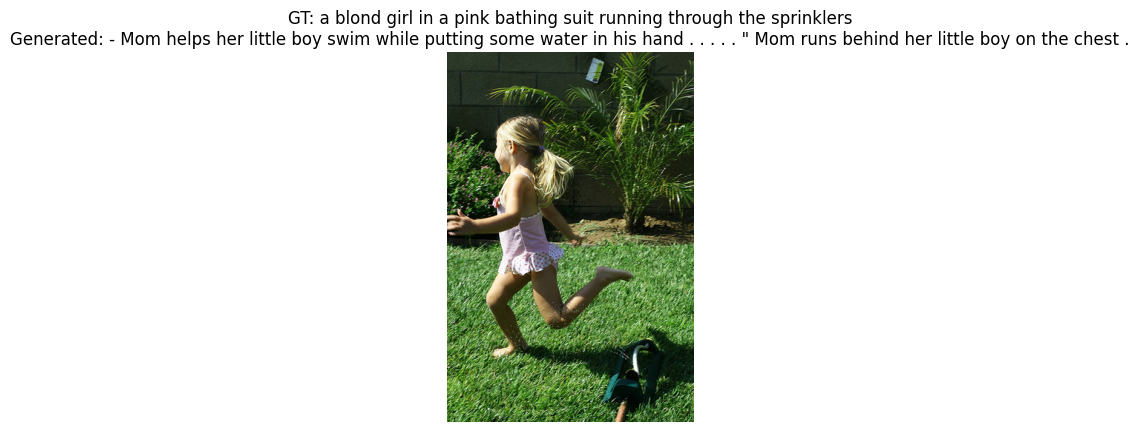

GT caption: A child is sliding into a small pool .
Generated caption: Introduction to fishing gear in a park . Wherever you are near water slide , be clear before heading down either side . . . . . . .


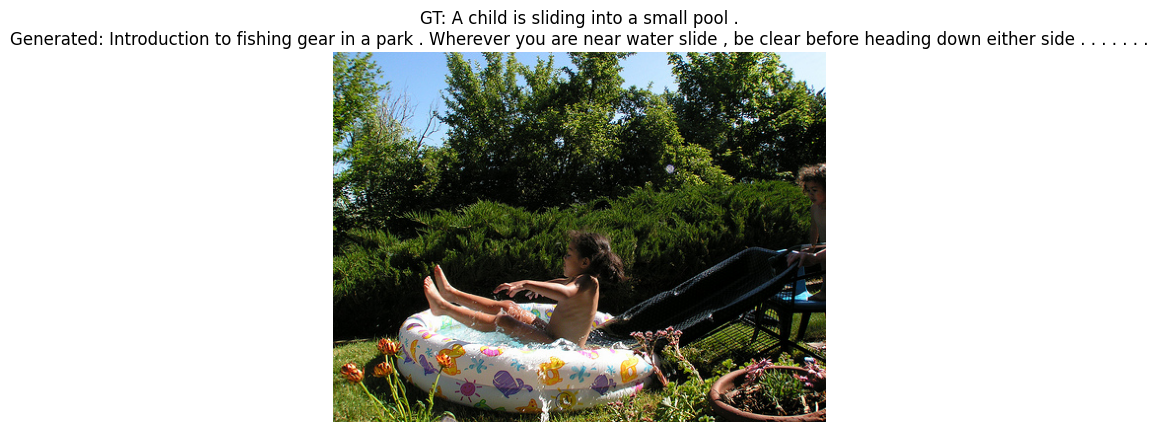

GT caption: A lone snowboarder wearing a white jacket jumping into the air on the snowy mountains .
Generated caption: Hello to the people behind Bohemian is spinning their wheels . . . . . . . . a small group of people in yellow jackets are riding in


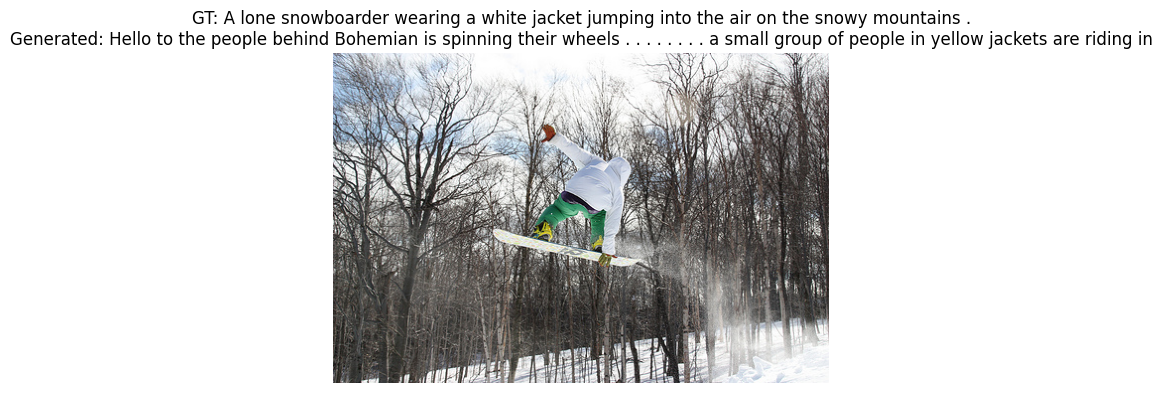

GT caption: A boy being pulled on a shovel .
Generated caption: I love eating ice cream on a shovel . . . . . . . . . . . . . . . . . . . . . .


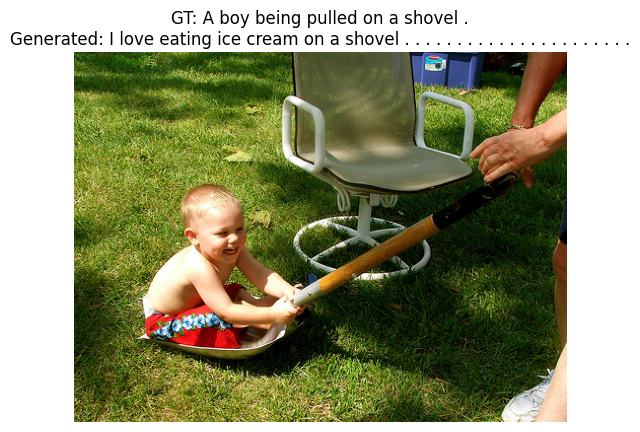

GT caption: A person is standing on a brick ledge taking a picture of something in the distance .
Generated caption: Scientists are standing in the sand . Rotation device in front of a brick wall . AT the top of it , near water . AT the bottom left


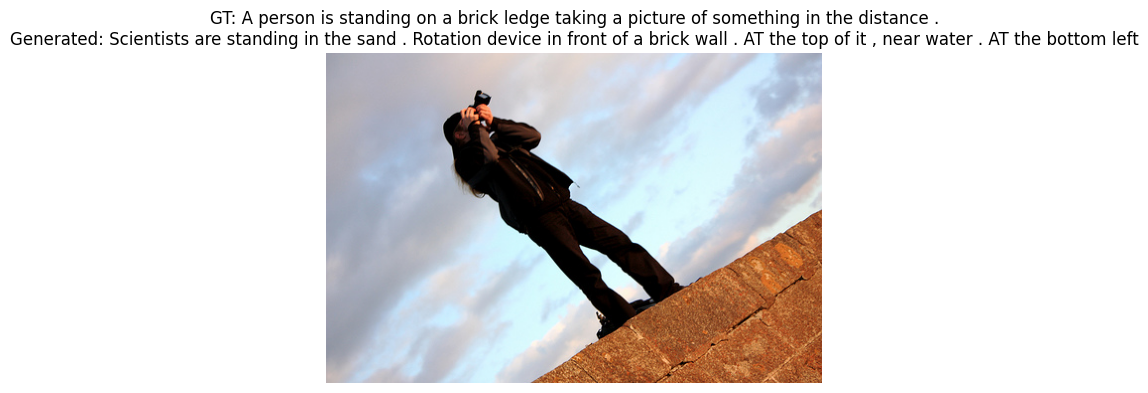

GT caption: A black dog and a brown dog with a yellow foam soccer ball toy on a grassy field
Generated caption: Challenges in a dog show . . . People in color playing soccer . . . dogs . . and a few dogs . . . . . walk


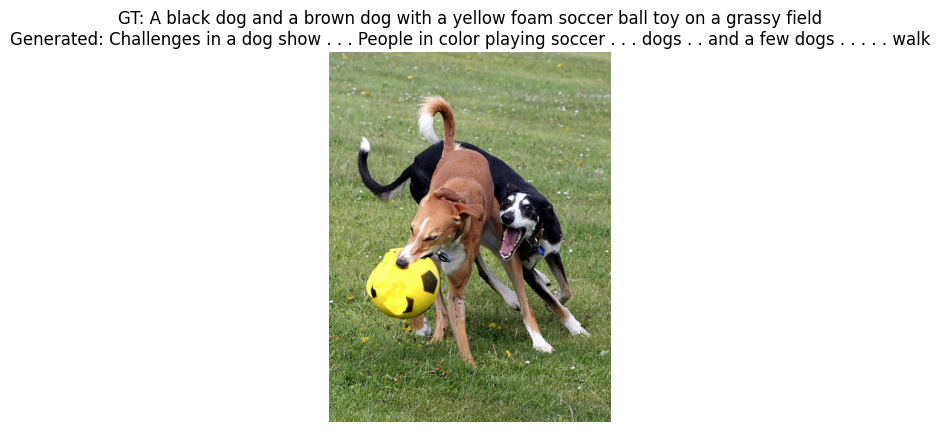

In [17]:
for i in range(100,110):
    img = flickr_data[i]['image']
    gt_caption = flickr_data[i]['caption_0']
    gen_caption = generate_caption(img, vit, q_former, gpt2, tokenizer, device)

    print("GT caption: " + gt_caption)
    print("Generated caption: " + gen_caption)

    plt.imshow(img)
    plt.title(f"GT: {gt_caption}\nGenerated: {gen_caption}")
    plt.axis('off')
    plt.show()

In [18]:
checkpoint = {
    "gpt2_state" : gpt2.state_dict(),
    "qformer" : q_former.state_dict(),
    "optimizer":optimizer.state_dict(),
    "epoch":epoch
}
torch.save(checkpoint,f"checkpoint_{epoch}.pth")